In [5]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini" , api_key=os.getenv("OPENAI_API_KEY"))

In [43]:
llm.invoke("hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C40LXI7asI2b2SNBHPzNyLiz6KtXT', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--26c021ba-9896-4289-96bb-85913049aba6-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [17]:
from typing import TypedDict, Optional, List
from typing_extensions import NotRequired


class Project(TypedDict):
    project_name: str
    github_link: NotRequired[Optional[str]]
    live_link: NotRequired[Optional[str]]
    time_period: NotRequired[Optional[str]]
    features: NotRequired[List[str]]
    tech_stack: NotRequired[List[str]]


class SkillsSection(TypedDict):
    programming_languages: NotRequired[List[str]]
    frameworks: NotRequired[List[str]]
    libraries_tools: NotRequired[List[str]]
    databases: NotRequired[List[str]]
    soft_skills: NotRequired[List[str]]


class Experience(TypedDict):
    role: str
    company: str
    start_date: NotRequired[Optional[str]]
    end_date: NotRequired[Optional[str]]
    responsibilities: NotRequired[List[str]]


class ExtracurricularActivity(TypedDict):
    title: str
    organization: NotRequired[Optional[str]]
    description: NotRequired[Optional[str]]
    date: NotRequired[Optional[str]]


class ResumeAgentState(TypedDict):
    message: NotRequired[Optional[str]]
    full_text: NotRequired[Optional[str]]
    links: NotRequired[List[dict]]

    # Personal Info
    name: NotRequired[Optional[str]]
    email: NotRequired[Optional[str]]
    mob_no: NotRequired[Optional[str]]

    # Profile Links
    linkedin: NotRequired[Optional[str]]
    github: NotRequired[Optional[str]]
    leetcode: NotRequired[Optional[str]]

    # Skills and Projects
    skills: NotRequired[SkillsSection]
    projects: NotRequired[List[Project]]

    # Experience and Extracurriculars
    experience: NotRequired[List[Experience]]
    extracurriculars: NotRequired[List[ExtracurricularActivity]]

In [18]:
from pydantic import BaseModel, EmailStr, HttpUrl, Field
from typing import Optional, List


class Project(BaseModel):
    project_name: str = Field(..., description="Name of the project")
    github_link: Optional[HttpUrl] = Field(None, description="GitHub URL of the project")
    live_link: Optional[HttpUrl] = Field(None, description="Live demo or deployment link")
    time_period: Optional[str] = Field(None, description="Time duration or dates of the project")
    features: Optional[List[str]] = Field(default_factory=list, description="Key features of the project")
    tech_stack: Optional[List[str]] = Field(default_factory=list, description="Technologies used in the project")


class SkillsSection(BaseModel):
    programming_languages: Optional[List[str]] = Field(default_factory=list, description="Languages like Python, C++")
    frameworks: Optional[List[str]] = Field(default_factory=list, description="Frameworks like Django, React")
    libraries_tools: Optional[List[str]] = Field(default_factory=list, description="Libraries and tools like NumPy, Git")
    databases: Optional[List[str]] = Field(default_factory=list, description="Databases like MongoDB, MySQL")
    soft_skills: Optional[List[str]] = Field(default_factory=list, description="Soft skills like leadership, communication")


class Experience(BaseModel):
    role: str = Field(..., description="Job title or position held")
    company: str = Field(..., description="Company or organization name")
    start_date: Optional[str] = Field(None, description="Start date in format YYYY-MM or similar")
    end_date: Optional[str] = Field(None, description="End date or 'Present'")
    responsibilities: Optional[List[str]] = Field(default_factory=list, description="Key responsibilities or achievements")


class ExtracurricularActivity(BaseModel):
    title: str = Field(..., description="Name of the activity or achievement")
    organization: Optional[str] = Field(None, description="Organization or club involved")
    description: Optional[str] = Field(None, description="Details of the activity")
    date: Optional[str] = Field(None, description="Date or time period of the activity")


class ExtractResumeData(BaseModel):
    # Personal Information
    name: Optional[str] = Field(None, description="Candidate's full name")
    email: Optional[EmailStr] = Field(None, description="Email address")
    mob_no: Optional[str] = Field(None, description="Mobile phone number")

    # Profiles
    linkedin: Optional[HttpUrl] = Field(None, description="LinkedIn profile URL")
    github: Optional[HttpUrl] = Field(None, description="GitHub profile URL")
    leetcode: Optional[HttpUrl] = Field(None, description="LeetCode profile URL")

    # Skills and Projects
    skills: Optional[SkillsSection] = Field(default_factory=SkillsSection, description="Structured skill information")
    projects: Optional[List[Project]] = Field(default_factory=list, description="List of personal or academic projects")

    # New Sections
    experience: Optional[List[Experience]] = Field(default_factory=list, description="Work or internship experience")
    extracurriculars: Optional[List[ExtracurricularActivity]] = Field(default_factory=list, description="Clubs, competitions, and other activities")

In [19]:

from langchain_groq import ChatGroq
from langchain_google_genai import ChatGoogleGenerativeAI

import os
from dotenv import load_dotenv
load_dotenv()
print(os.getenv("GROQ_MODEL_NAME"))

# llm = ChatGroq(model="llama-3.3-70b-versatile")
llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro" , api_key=os.getenv("GOOGLE_API_KEY"))

def load_llm():
    return llm

llama-3.3-70b-versatile


In [20]:
def extract_resume_data(state: ResumeAgentState) -> ResumeAgentState:
    print("In extract_resume_data")
    try:
        # Load the LLM configured for structured output using the ExtractResumeData schema
        llm = load_llm().with_structured_output(ExtractResumeData)
        
        # Extract full_text and links from the agent state
        full_text = state.get('full_text' , '')
        links = state.get('links' , [])

        # Format all link entries with keys: page, text, and url
        formatted_links = "\n".join(
            f"Page: {link.get('page', '')}, Text: {link.get('text', '')}, URL: {link.get('url', '')}"
            for link in links
        )

        # Final input string to be passed to the LLM
        resume_input = f"{full_text}\n\nLinks:\n{formatted_links}"

        # Extract structured resume data from the LLM
        extracted_data = llm.invoke(resume_input)

        # Return new state with extracted fields merged into ResumeAgentState
        return extracted_data.model_dump()

    except Exception as e:
        raise RuntimeError(f"Failed to extract resume data: {e}")

In [21]:
import requests

def check_links_and_alert(state: ResumeAgentState) -> ResumeAgentState:
    print("Check links")
    broken_links = []
    
    for key, value in state.items():
        if key in ("full_text", "links"):
            continue
        if isinstance(value, list):
            for item in value:
                if isinstance(item, dict):
                    for k, v in item.items():
                        if isinstance(v, str) and v.startswith("http"):
                            try:
                                response = requests.get(v, timeout=5)
                                if response.status_code >= 400:
                                    broken_links.append((k, v, response.status_code))
                            except Exception:
                                broken_links.append((k, v, "Error"))
        elif isinstance(value, str) and value.startswith("http"):
            try:
                response = requests.get(value, timeout=5)
                if response.status_code >= 400:
                    broken_links.append((key, value, response.status_code))
            except Exception:
                broken_links.append((key, value, "Error"))

    if broken_links:
        msg = "🚨 Some links in your resume are not working:\n"
        for k, link, status in broken_links:
            msg += f"- **Key**: `{k}` | **Link**: {link} | **Status**: {status}\n"
        msg += "\n🔁 Please update these links in your resume."
    else:
        msg = "✅ All good! All details are fetched successfully and your links are working fine."

    return {"message":msg}

In [22]:
def response(state: ResumeAgentState) -> ResumeAgentState:
    return

In [23]:

from langgraph.graph import StateGraph , START , END
def build_graph():

    builder = StateGraph(ResumeAgentState)

    builder.add_node("extract_resume_data" , extract_resume_data)
    builder.add_node("check_links_and_alert" , check_links_and_alert)
    # builder.add_node("response" , response)

    builder.add_edge(START , "extract_resume_data")
    builder.add_edge("extract_resume_data" , "check_links_and_alert")
    builder.add_edge("check_links_and_alert" ,END)
    # builder.add_edge("response" , END)

    graph = builder.compile()
    return graph

In [24]:
graph = build_graph()

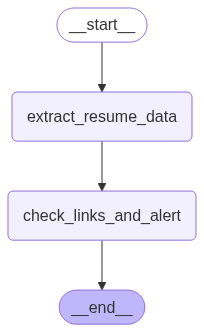

In [25]:
from IPython.display import Image , display
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
import fitz  # PyMuPDF

def extract_text_and_links(pdf_path: str):
    full_text = ""
    links = []

    pdf = fitz.open(pdf_path)
    
    for page_num, page in enumerate(pdf, start=1):
        full_text += page.get_text()

        # Extract links on this page
        for link in page.get_links():
            uri = link.get("uri", None)
            rect = link.get("from", None)
            if uri and rect:
                # Get anchor text behind the link
                anchor_text = page.get_textbox(rect)
                links.append({
                    "page": page_num,
                    "text": anchor_text.strip(),
                    "url": uri.strip()
                })

    pdf.close()

    return full_text, links

In [27]:
text , links = extract_text_and_links("Shubham_resume_with_photo.pdf")

In [28]:
print(text[:50])

 
Shubham Dahane 
shubhamdahane09yz@gmail.com | (+


In [29]:
links[:3]

[{'page': 1,
  'text': 'ShubhamDahane18',
  'url': 'https://github.com/ShubhamDahane18'},
 {'page': 1,
  'text': 'ShubhamDahane18',
  'url': 'https://github.com/ShubhamDahane18'},
 {'page': 1,
  'text': 'ShubhamDahane18',
  'url': 'https://github.com/ShubhamDahane18'}]

In [30]:
resume_input = text + "\n\nLinks:\n" + "\n".join(
    f"Page: {link['page']}, Text: {link['text']}, URL: {link['url']}" for link in links
)

In [31]:
resume_input

" \nShubham Dahane \nshubhamdahane09yz@gmail.com | (+91) 7666174552 \n \nShubhamDahane18                                                                                                  \nShubham Dahane \n \nSKILLS \n❖ Programming Languages: Python | C++ \n❖ Technologies And Frameworks: AI | ML | DL | Gen AI | TensorFlow | PyTorch | \nLangChain | LangGraph | HTML | CSS| Javascript | VectorDB | MongoDB \n❖ Tools: Git, GitHub, Docker \nEDUCATION \n❖ BRACT’s Vishwakarma Institute of Information Technology, Pune \nB. Tech Computer Science & Engineering (AI), 2023 – 2027 (CGPA – 8.44)  \n❖ Yashwantrao Chavan Secondary And Higher Secondary School Kajalamba, Washim  \nHSC 97.83%, 2020 – 2021 (Rank 1)  \n❖ Yashwantrao Chavan Secondary And Higher Secondary School Kajalamba, Washim  \nSchool education up to March 2019, SSC 91.00% (Rank 1) \n \nACADEMIC PROJECTS \n❖ End to End Agentic AI Chatbot with Tools  \n \n \n    \nBuilt an Agentic AI Chatbot using LangGraph with Groq models (LLaMA3 & Gemma

In [32]:
input_state = {
                "full_text": text,
                "links": links
            }

In [33]:
state = graph.invoke(input_state)

In extract_resume_data
Check links


In [35]:
state

{'message': '✅ All good! All details are fetched successfully and your links are working fine.',
 'full_text': " \nShubham Dahane \nshubhamdahane09yz@gmail.com | (+91) 7666174552 \n \nShubhamDahane18                                                                                                  \nShubham Dahane \n \nSKILLS \n❖ Programming Languages: Python | C++ \n❖ Technologies And Frameworks: AI | ML | DL | Gen AI | TensorFlow | PyTorch | \nLangChain | LangGraph | HTML | CSS| Javascript | VectorDB | MongoDB \n❖ Tools: Git, GitHub, Docker \nEDUCATION \n❖ BRACT’s Vishwakarma Institute of Information Technology, Pune \nB. Tech Computer Science & Engineering (AI), 2023 – 2027 (CGPA – 8.44)  \n❖ Yashwantrao Chavan Secondary And Higher Secondary School Kajalamba, Washim  \nHSC 97.83%, 2020 – 2021 (Rank 1)  \n❖ Yashwantrao Chavan Secondary And Higher Secondary School Kajalamba, Washim  \nSchool education up to March 2019, SSC 91.00% (Rank 1) \n \nACADEMIC PROJECTS \n❖ End to End Agentic AI

# Job Info

In [36]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini" , api_key=os.getenv("OPENAI_API_KEY"))

In [37]:
from typing import TypedDict, Optional, List
from typing_extensions import NotRequired

In [38]:
class JobInfoState(TypedDict):
    response: str
    user_input: str
    job_title: str
    company: Optional[str]
    location: NotRequired[Optional[str]]
    job_type: NotRequired[Optional[str]]  # Full-time, Internship, etc.
    description: NotRequired[Optional[str]]
    required_skills: NotRequired[List[str]]

In [39]:
from pydantic import BaseModel, EmailStr, HttpUrl, Field
from typing import Optional, List

In [40]:
class ExtractJobInfo(BaseModel):
    job_title: str = Field(..., description="Title of the job role, e.g., Software Engineer, Data Analyst")
    company: Optional[str] = Field(None, description="Name of the company offering the job")
    location: Optional[str] = Field(None, description="Job location, e.g., city, state, or remote")
    job_type: Optional[str] = Field(None, description="Type of job, e.g., Full-time, Internship, Contract")
    description: Optional[str] = Field(None, description="Full job description text")
    required_skills: List[str] = Field(default_factory=list, description="List of skills required for the job role given by user.")

In [41]:
from langchain_core.prompts import PromptTemplate
check_state_prompt = PromptTemplate(
    template="""
You are given structured job info extracted from the user.

{state}

If any key fields are missing (job_title, company, location, required_skills), 
ask the user specifically for them. 
If all are present, say: "Great! I have all the details. You can proceed."
""",
    input_variables=["state"]
)

In [42]:
from langchain_core.output_parsers import StrOutputParser

In [43]:
def parse_info(state:JobInfoState) -> JobInfoState:
    text = state["user_input"]
    llm_strc = llm.with_structured_output(ExtractJobInfo)
    result = llm_strc.invoke(text)
    return result.model_dump()

def response(state:JobInfoState) -> JobInfoState:
    chain = check_state_prompt | llm | StrOutputParser()
    message = chain.invoke({"state": state})
    return {"response": message}

# --- Graph setup ---
graph = StateGraph(JobInfoState)

graph.add_node("parse_info", parse_info)
graph.add_node("response", response)

graph.add_edge(START, "parse_info")
graph.add_edge("parse_info", "response")
graph.add_edge("response", END)

app = graph.compile()


In [44]:
# ---------- Run ----------
if __name__ == "__main__":
    state = {}
    while True:
        user_text = input("You: ")
        state["user_input"] = user_text
        result = app.invoke(state)
        print(f"Bot: {result}")

Bot: {'response': "It looks like I'm missing some information. Could you please provide the following details:\n\n1. Location of the job.\n2. Job type (e.g., full-time, part-time, contract).\n3. Description of the job (if available).\n4. Required skills for the position.\n\nOnce I have this information, I can assist you further!", 'user_input': 'I am applying for the position of Data Scientist at TechNova Solutions', 'job_title': 'Data Scientist', 'company': 'TechNova Solutions', 'location': None, 'job_type': None, 'description': None, 'required_skills': []}
Bot: {'response': 'It looks like I have most of the details, but I need a bit more information. Could you please provide the location, job type, and any required skills for the Data Scientist position at TechNova Solutions?', 'user_input': 'I am applying for the position of Data Scientist at TechNova Solutions', 'job_title': 'Data Scientist', 'company': 'TechNova Solutions', 'location': None, 'job_type': None, 'description': None, 

KeyboardInterrupt: 